# Telecom Customer Churn Prediction Project

This notebook performs an end-to-end analysis on the Telco Customer Churn dataset. The goal is to predict which customers is likely cancelling their telecom service and to understand the factors most assocciated with churn.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import confusion_matrix

## 1. Import Required Libraries

All necessary Python libraries are imported in the first cell.

In [2]:
df = pd.read_csv("../data/Telco-Customer-Churn-Data.csv")

## 2. Load the Dataset

The dataset is loaded from a CSV file into a pandas DataFrame named `df`. Each row represents a single customer, and the column `Churn` indicates whether the customer left (1) or stayed (0).


In [3]:
print(df.shape)
df.head()

(7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
print(df.columns)
print(df.dtypes)
print(df.isnull().sum())
print(df["Churn"].value_counts(normalize=True))

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')
customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object
customerID       

## 3. Data Cleaning

 Initial inspection showed that the `TotalCharges` column was interpreted as text. It is converted to numeric. A small number of invalid rows are removed.


In [5]:
# Convert TotalCharges from text to numeric
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")

In [6]:
print(df.isnull().sum())

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64


In [7]:
# Drop rows with missing TotalCharges
df = df.dropna(subset=["TotalCharges"])

In [8]:
df = df.replace("No phone service", "No")
df = df.replace("No internet service", "No")

In [9]:
df["Churn"] = df["Churn"].map({"No": 0, "Yes": 1})

In [10]:
print(df.shape)
df.head()

(7032, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,0
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
3,7795-CFOCW,Male,0,No,No,45,No,No,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1


In [11]:
df["Churn"].value_counts(normalize=True)

Churn
0    0.734215
1    0.265785
Name: proportion, dtype: float64

## Our data cleaning was careful and did not introduce bias

In [12]:
# Split dataset into predictors (X) and target (y)
X = df.drop("Churn", axis=1)
y = df["Churn"]

print(X.shape)
print(y.shape)

(7032, 20)
(7032,)


In [13]:
numeric_cols = ["tenure", "MonthlyCharges", "TotalCharges", "SeniorCitizen"]

In [14]:
# customerID is dropped because it is only an identifier.
df = df.drop("customerID", axis=1)

### Drop Unnecessary Identifier

The column `customerID` is dropped because it is only an identifier. Leaving this column inside X would cause one-hot encoding to create thousands of useless features.


In [15]:
X = df.drop("Churn", axis=1)
y = df["Churn"]

## 4. Encode Categorical Variables

Most predictors in the dataset are categorical. o categorical variables are transformed into binary dummy variables using pandas one-hot encoding to avoid redundancy.


In [16]:
X_encoded = pd.get_dummies(X, drop_first=True)

print(X_encoded.shape)
X_encoded.head()

(7032, 23)


,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_Yes,InternetService_Fiber optic,...,DeviceProtection_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,1,29.85,29.85,False,True,False,False,False,False,...,False,False,False,False,False,False,True,False,True,False
1,0,34,56.95,1889.50,True,False,False,True,False,False,...,True,False,False,False,True,False,False,False,False,True
2,0,2,53.85,108.15,True,False,False,True,False,False,...,False,False,False,False,False,False,True,False,False,True
3,0,45,42.30,1840.75,True,False,False,False,False,False,...,True,True,False,False,True,False,False,False,False,False
4,0,2,70.70,151.65,False,False,False,True,False,True,...,False,False,False,False,False,False,True,False,True,False


## 5. Train-Test Split

The encoded dataset is split into training and testing sets. Stratifying on `y` ensures that both sets preserve the same churn proportion (~26.5%). This prevents biased evaluation.


In [17]:
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42, stratify=y
)

print(X_train.shape)
print(X_test.shape)

(5625, 23)
(1407, 23)


## 6. Baseline Model – Logistic Regression

Logistic regression is used as the initial baseline model. It assumption linear relationships between features and churn. 

In [18]:
model = LogisticRegression(max_iter=5000, solver="liblinear")
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))
print(classification_report(y_test, y_pred))

Accuracy: 0.8024164889836531
ROC-AUC: 0.8369411039959415
              precision    recall  f1-score   support

           0       0.85      0.89      0.87      1033
           1       0.65      0.56      0.60       374

    accuracy                           0.80      1407
   macro avg       0.75      0.73      0.74      1407
weighted avg       0.80      0.80      0.80      1407



## 7. Nonlinear Model – Random Forest

A Random Forest classifier is train to capture nonlinear patterns &interactions between features


In [19]:
rf = RandomForestClassifier(
    n_estimators=200,
    random_state=42
)

rf.fit(X_train, y_train)

# Evaluate baseline RF in the same cell
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix

y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)[:, 1]

print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Random Forest ROC-AUC:", roc_auc_score(y_test, y_prob_rf))
print(classification_report(y_test, y_pred_rf))


Random Forest Accuracy: 0.7910447761194029
Random Forest ROC-AUC: 0.8206576038846409
              precision    recall  f1-score   support

           0       0.83      0.89      0.86      1033
           1       0.63      0.51      0.56       374

    accuracy                           0.79      1407
   macro avg       0.73      0.70      0.71      1407
weighted avg       0.78      0.79      0.78      1407



### Hyperparameter Tuning

The initial Random Forest underperformed due to class imbalance and lack of depth control. A tuned RF model is trained to improve focus on churn prediction.


In [20]:
print("Tuning max_depth with 5-fold CV (ROC-AUC):")

for d in [6, 8, 10, 12]:
    rf_cv = RandomForestClassifier(
        n_estimators=300,
        max_depth=d,
        min_samples_leaf=5,
        class_weight="balanced",
        random_state=42
    )

    scores = cross_val_score(rf_cv, X_encoded, y, cv=5, scoring="roc_auc")
    print(f"max_depth={d} -> mean ROC-AUC: {scores.mean():.4f} (std: {scores.std():.4f})")

Tuning max_depth with 5-fold CV (ROC-AUC):
max_depth=6 -> mean ROC-AUC: 0.8466 (std: 0.0108)
max_depth=8 -> mean ROC-AUC: 0.8469 (std: 0.0116)
max_depth=10 -> mean ROC-AUC: 0.8465 (std: 0.0116)
max_depth=12 -> mean ROC-AUC: 0.8452 (std: 0.0121)


In [21]:
# Train final tuned RF with the best max_depth from CV
rf_tuned = RandomForestClassifier(
    n_estimators=300,
    max_depth=10,  # <-- replace with best depth from the tuning loop
    min_samples_leaf=5,
    class_weight="balanced",
    random_state=42
)

rf_tuned.fit(X_train, y_train)

# Evaluate tuned RF
y_pred_tuned = rf_tuned.predict(X_test)
y_prob_tuned = rf_tuned.predict_proba(X_test)[:, 1]

print("Tuned RF Accuracy:", accuracy_score(y_test, y_pred_tuned))
print("Tuned RF ROC-AUC:", roc_auc_score(y_test, y_prob_tuned))
print(classification_report(y_test, y_pred_tuned))


Tuned RF Accuracy: 0.7604832977967306
Tuned RF ROC-AUC: 0.838125287957302
              precision    recall  f1-score   support

           0       0.90      0.76      0.82      1033
           1       0.53      0.76      0.63       374

    accuracy                           0.76      1407
   macro avg       0.72      0.76      0.73      1407
weighted avg       0.80      0.76      0.77      1407



In [22]:
print("Logistic Regression ROC-AUC:", roc_auc_score(y_test, y_prob))
print("Basic Random Forest ROC-AUC:", roc_auc_score(y_test, y_prob_rf))
print("Tuned Random Forest ROC-AUC:", roc_auc_score(y_test, y_prob_tuned))

Logistic Regression ROC-AUC: 0.8369411039959415
Basic Random Forest ROC-AUC: 0.8206576038846409
Tuned Random Forest ROC-AUC: 0.838125287957302


In [23]:
cv_scores = cross_val_score(rf_tuned, X_encoded, y, cv=5, scoring="roc_auc")

print("CV ROC-AUC Scores:", cv_scores)
print("Mean CV ROC-AUC:", cv_scores.mean())
print("Std Dev:", cv_scores.std())

CV ROC-AUC Scores: [0.86073997 0.85883104 0.83062555 0.8386045  0.84381866]
Mean CV ROC-AUC: 0.8465239411985854
Std Dev: 0.011630605815627857


## 8. Cross-Validation Evaluation

Model performance is validated using 5-fold cross-validation with ROC-AUC scoring. This evaluates stability and generalizability beyond a single train-test split.


In [24]:
importances = pd.Series(
    rf_tuned.feature_importances_,
    index=X_encoded.columns
).sort_values(ascending=False)

print(importances.head(10))

tenure                            0.185728
TotalCharges                      0.132880
MonthlyCharges                    0.117580
Contract_Two year                 0.113865
InternetService_Fiber optic       0.088826
PaymentMethod_Electronic check    0.063010
Contract_One year                 0.051584
InternetService_No                0.050262
OnlineSecurity_Yes                0.027385
TechSupport_Yes                   0.022347
dtype: float64


## 9. Feature Importance Interpretation

The tuned Random Forest provides importance scores for each predictor. These values help explain which variables contribute most to churn risk and guide potential business actions.


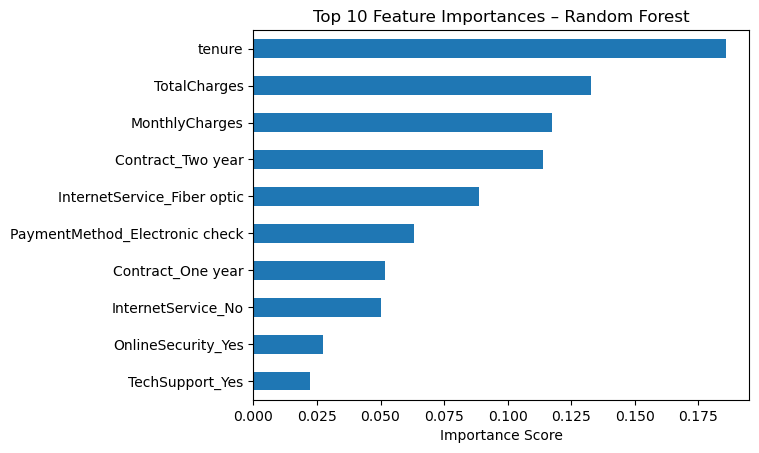

In [25]:
plt.figure()
importances.head(10).sort_values().plot(kind="barh")
plt.title("Top 10 Feature Importances – Random Forest")
plt.xlabel("Importance Score")
plt.show()

<Figure size 640x480 with 0 Axes>

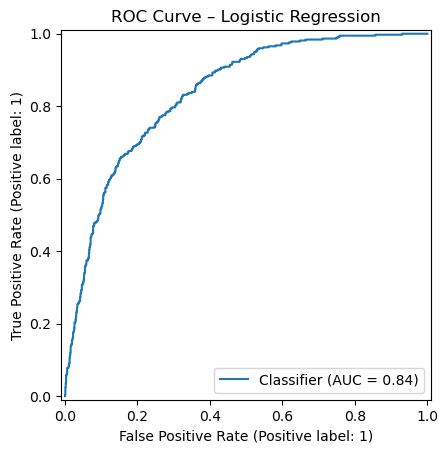

In [26]:
plt.figure()
RocCurveDisplay.from_predictions(y_test, y_prob)
plt.title("ROC Curve – Logistic Regression")
plt.show()

## 10. Threshold Adjustment Experiment

Classification metrics depend on the decision threshold. The default threshold (0.5) is adjusted to 0.40 to analyze precision–recall tradeoffs and better align the model with a customer-retention objective.


In [27]:
# Try a custom threshold
threshold = 0.40
y_custom = (y_prob_tuned >= threshold).astype(int)

print("Confusion Matrix at threshold 0.40:")
print(confusion_matrix(y_test, y_custom))
print(classification_report(y_test, y_custom))

Confusion Matrix at threshold 0.40:
[[694 339]
 [ 59 315]]
              precision    recall  f1-score   support

           0       0.92      0.67      0.78      1033
           1       0.48      0.84      0.61       374

    accuracy                           0.72      1407
   macro avg       0.70      0.76      0.69      1407
weighted avg       0.80      0.72      0.73      1407



# Final Conclusions

- Logistic Regression and tuned Random Forest achieved similar ROC-AUC (~0.84).
- Random Forest tuning improved churn recall substantially.
- Customer tenure, billing amounts, and contract type are the strongest predictors.
- The project demonstrates an end-to-end machine learning workflow including data cleaning, encoding, evaluation, and interpretation.
